In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from openpyxl import load_workbook
from openpyxl.styles import Font
df = pd.read_excel('数据2.xlsx')

# 定义转换函数
def quarter_to_date(quarter_str):
    year, quarter = quarter_str[:-4], quarter_str[-3:]
    quarter_dict = {"季度一": "03-31", "季度二": "06-30", "季度三": "09-30", "季度四": "12-31"}
    return pd.to_datetime(f"{year}-{quarter_dict[quarter]}")
# 将表头转换为日期格式
new_index = [quarter_to_date(q) for q in df.columns]
df.columns = new_index
df = df.T
indexs = ['GDP', '居民消费水平', '社会消费品零售', '固定资产投资', '出口', '进口', '财政支出']
df.columns = indexs

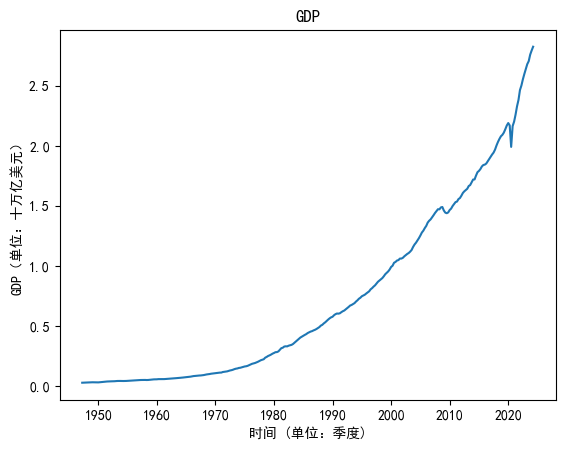

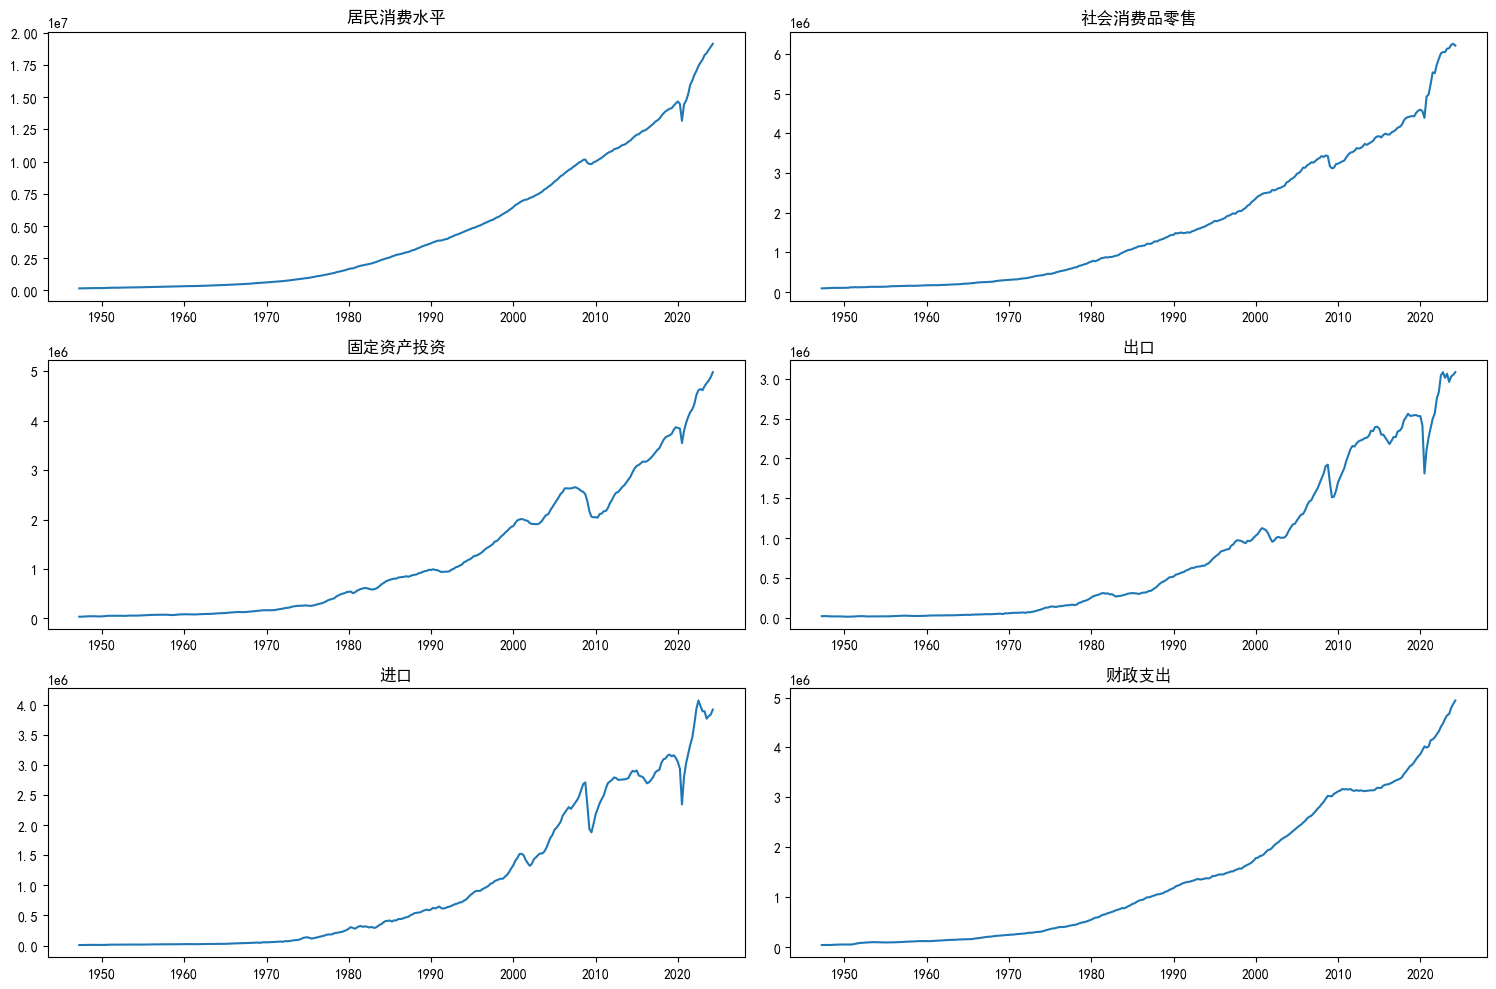

In [11]:
plt.plot(df.iloc[:, 0]/1e7)
plt.title(df.columns[0])
plt.xlabel('时间 (单位：季度)')
plt.ylabel('GDP（单位：十万亿美元）')
plt.savefig('结果1-2/GDP.png')
plt.show()

fig, axes = plt.subplots(3, 2, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i+1]]
    ax.plot(data)
    ax.set_title(df.columns[i+1])
plt.tight_layout()
plt.savefig('结果1-2/六项.png')
plt.show()


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=306, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=0.0000  , p=1.0000  , df=1
parameter F test:         F=620669.8452, p=0.0000  , df_denom=306, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=304, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=0.0000  , p=1.0000  , df=2
parameter F test:         F=312291.2323, p=0.0000  , df_denom=304, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2516  , p=0.6163  , df_denom=305, df_num=1
ssr based chi2 test:   chi2=0.2540  , p=0.6143  , df=1
likelihood ratio test: chi2=0.2539  , p=0.6143  , df=1
parameter F test:         F=0.2516  , p=0.6163  , df_denom=305, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4461  , p=0.

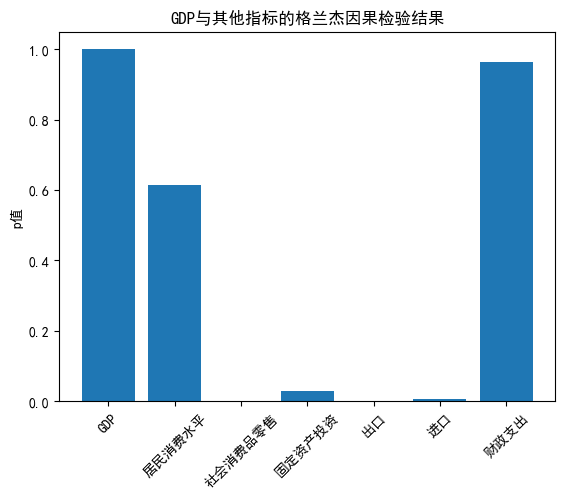

In [12]:
results_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)
for col1 in df.columns:
    for col2 in df.columns:
        # 进行格兰杰因果测试
        test_result = grangercausalitytests(df[[col1, col2]], maxlag=2)
        p_value = test_result[1][0]['ssr_chi2test'][1]
        # 将p值存储在结果矩阵中的相应位置
        results_matrix.loc[col1, col2] = p_value

# 输出结果
print(results_matrix)
results_matrix.to_excel('结果1-2/格兰杰因果检验.xlsx')
plt.bar(df.columns, results_matrix.iloc[0])
plt.title('GDP与其他指标的格兰杰因果检验结果')
plt.ylabel('p值')
plt.xticks(rotation=45)
plt.show()


In [13]:
train = df[['社会消费品零售', '出口', '进口', '财政支出', 'GDP']]
columns = ['原始数据', '一阶差分', '二阶差分']

p_values = pd.DataFrame(index=train.columns, columns=columns, dtype=float)

# 循环进行0次、1次、2次差分
for diff_level in range(3):
    if diff_level == 0:
        data_diff = train
        column_name = '原始数据'
    else:
        data_diff = data_diff.diff().dropna()
        column_name = columns[diff_level]    
    # 对每一列进行ADF测试
    for col in data_diff.columns:
        result = adfuller(data_diff[col])
        p_values.loc[col, column_name] = result[1]


excel_path = '结果1-2/ADF检验.xlsx'
p_values.to_excel(excel_path)


wb = load_workbook(excel_path)
ws = wb.active

# 遍历p值DataFrame，将p值小于0.05的单元格标红
for row in range(2, len(p_values) + 2):  # Excel行列索引从1开始，且跳过标题行
    for col in range(2, len(p_values.columns) + 2):  # 跳过索引列
        _value = ws.cell(row=row, column=col).value
        if _value < 0.05:
            ws.cell(row=row, column=col).font = Font(color="FF0000")

# 保存修改后的工作簿
wb.save(excel_path)


c:\Users\Timothy\Desktop\python\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


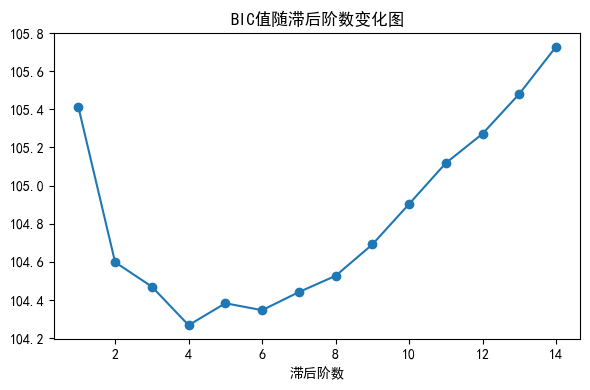

In [15]:
model = VAR(train_diff_diff)

# 初始化存储结果的字典
criteria = {'BIC': []}
lags = range(1, 15)

# 计算每个滞后阶数下的BIC值
for i in lags:
    result = model.fit(i)
    criteria['BIC'].append(result.bic)

# 绘制BIC图
plt.figure(figsize=(6, 4))
plt.plot(lags, criteria['BIC'], marker='o')
plt.title('BIC值随滞后阶数变化图')
plt.xlabel('滞后阶数')
# plt.ylabel('值')
plt.tight_layout()
plt.savefig('结果1-2/BIC.png')
plt.show()

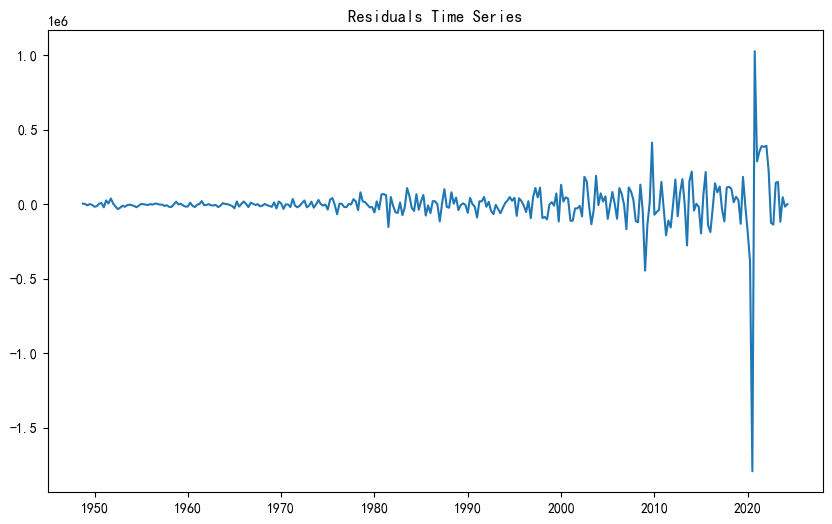

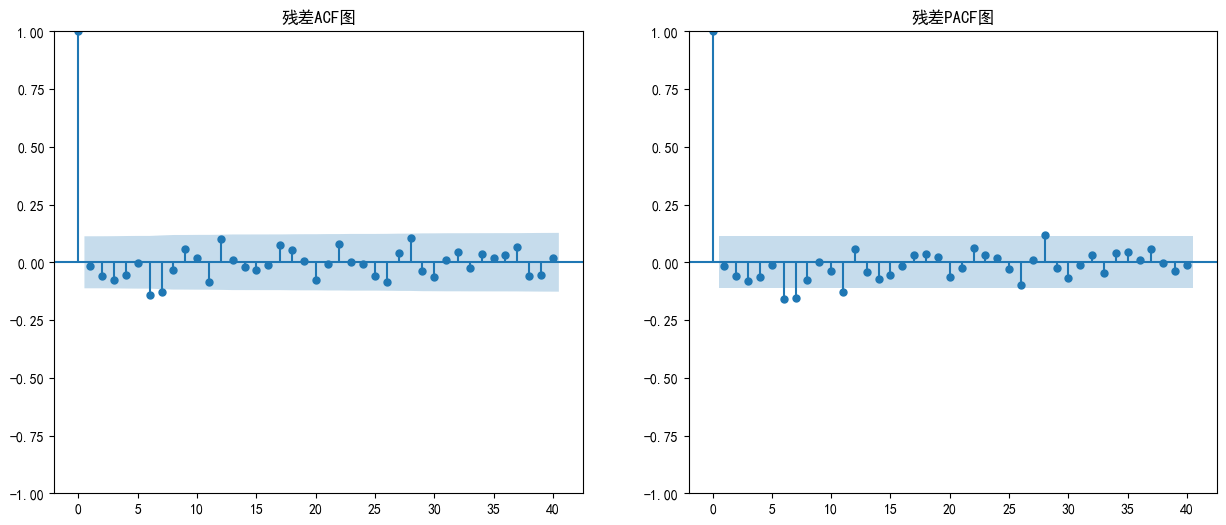

<Figure size 1000x600 with 0 Axes>

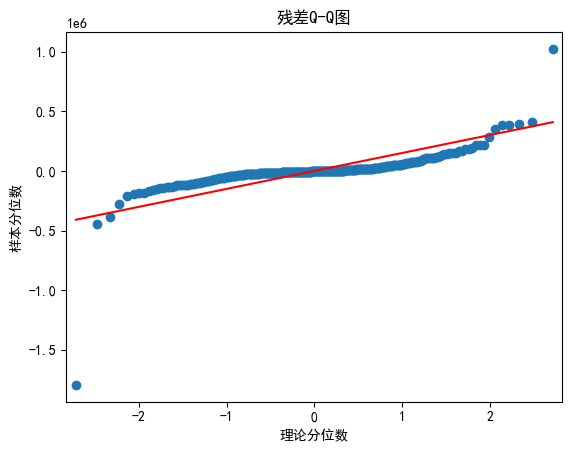

In [16]:
model_fitted = model.fit(4)
# model_fitted.summary()


# 假设model_fitted是已经拟合好的VAR模型对象
residuals = model_fitted.resid
# print(residuals.loc[:, 'GDP'].head())
residuals = residuals.loc[:, 'GDP']

# 残差的时间序列图
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals Time Series')
plt.show()

# 残差的ACF图和PACF图
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sm.graphics.tsa.plot_acf(residuals.values.squeeze(), lags=40, ax=axes[0], title='残差ACF图')
sm.graphics.tsa.plot_pacf(residuals.values.squeeze(), lags=40, ax=axes[1], title='残差PACF图')
plt.savefig('结果1-2/残差ACFPACF图.png')
plt.show()

# Q-Q图
plt.figure(figsize=(10, 6))
sm.qqplot(residuals.values.ravel(), line='s')
plt.title('残差Q-Q图')
plt.savefig('结果1-2/残差QQ图.png')
plt.xlabel('理论分位数')
plt.ylabel('样本分位数')
plt.show()

In [17]:
out = durbin_watson(model_fitted.resid)
for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

GDP : 2.06
居民消费水平 : 1.99
社会消费品零售 : 2.03
固定资产投资 : 2.02
出口 : 2.04


In [18]:
model = VAR(train_diff_diff)
model_fitted = model.fit(4)
# 预测未来7个季度
forecasted_values_diff = model_fitted.forecast(train_diff_diff.values[-model_fitted.k_ar:], steps=7)
# 首先，将二阶差分的预测值还原为一阶差分的尺度
last_observation_diff = train_diff.iloc[-1].values
forecasted_values_diff_cumsum = forecasted_values_diff.cumsum(axis=0)
forecasted_values_diff_cumsum += last_observation_diff
# 然后，将一阶差分的预测值还原为原始尺度的值
last_original_observation = train.iloc[-1].values
forecasted_values_original = forecasted_values_diff_cumsum.cumsum(axis=0)
forecasted_values_original += last_original_observation

c:\Users\Timothy\Desktop\python\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


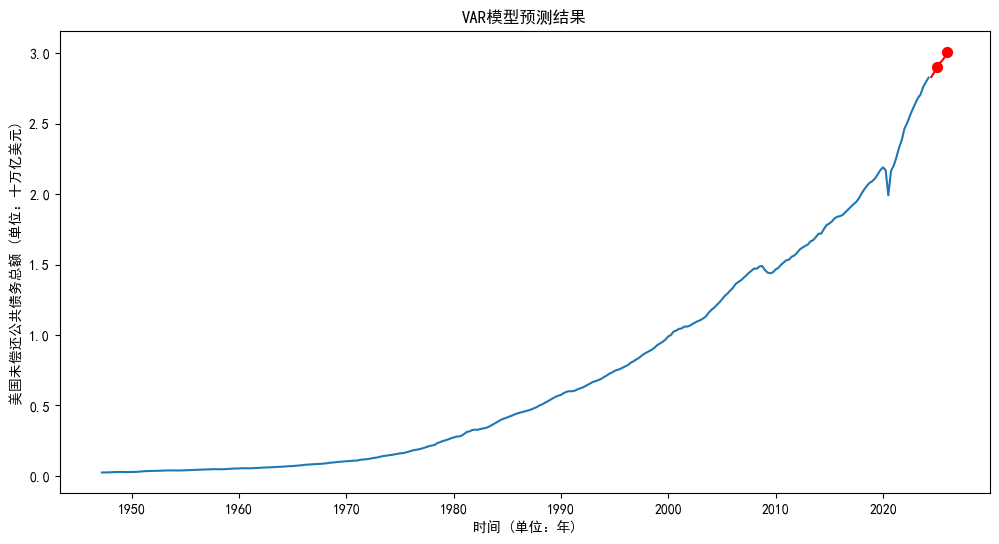

In [33]:
# 确保 train_forecasted.index 是 DatetimeIndex 类型
train_forecasted.index = pd.to_datetime(train_forecasted.index)

plt.figure(figsize=(12, 6))
plt.plot(train_forecasted['GDP'].iloc[:-7]/1e7, label='历史数据')
plt.plot(train_forecasted['GDP'].iloc[-7:]/1e7, label='预测数据', color='red')
plt.title('VAR模型预测结果')
plt.xlabel('时间 (单位：年)')
plt.ylabel('美国未偿还公共债务总额 (单位：十万亿美元)')

# 特定日期
dates_to_highlight = ['2024-12-31', '2025-12-31']

# 在图上用红色圆点标记特定日期
for date in dates_to_highlight:
    date_time = pd.to_datetime(date)  # 将字符串日期转换为日期时间对象
    if date_time in train_forecasted.index:
        plt.scatter(date_time, train_forecasted.loc[date_time, 'GDP']/1e7, color='red', s=50)  # s是点的大小

plt.savefig('结果1-2/VAR模型预测结果.png')
plt.show()

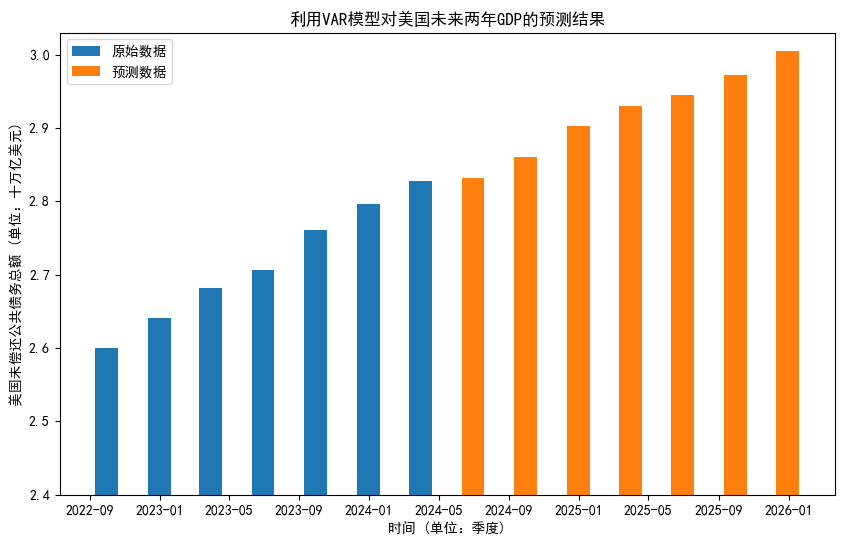

In [20]:
# 绘制原始GDP数据
plt.figure(figsize=(10, 6))
plt.bar(df.index[-7:], df['GDP'][-7:]/1e7, width=40, label='原始数据')
# 绘制预测GDP数据
plt.bar(forecasted_df.index, forecasted_df['GDP']/1e7, width=40, label='预测数据')
plt.legend()
plt.title('利用VAR模型对美国未来两年GDP的预测结果')
plt.xlabel('时间 (单位：季度)')
plt.ylabel('美国未偿还公共债务总额 (单位：十万亿美元)')
plt.ylim(2.4, 3.03)
plt.savefig('结果1-2/预测.png')
plt.show()